# Data Mining Project
## Konstantinos Georgiou
Dataset: [COVID-19 World Vaccination Progress](https://www.kaggle.com/gpreda/covid-world-vaccination-progress)

# Information About The Dataset

This dataset contains information about the vaccinations happening in each country daily. The data are being collected almost daily from this website using this code. As of writing this (2/27), the dataset has 4,380 rows with vaccination data for 112 unique countries and is in the CSV format.

It has 15 columns in total, including among others the country name, the daily vaccination, the vaccinated people per million that date, and the source of each record.

- Country- this is the country for which the vaccination information is provided;
- Country ISO Code - ISO code for the country;
- Date - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;
- Total number of vaccinations - this is the absolute number of total immunizations in the country;
- Total number of people vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;
- Total number of people fully vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;
- Daily vaccinations (raw) - for a certain data entry, the number of vaccination for that date/country;
- Daily vaccinations - for a certain data entry, the number of vaccination for that date/country;
- Total vaccinations per hundred - ratio (in percent) between vaccination number and total population up to the date in the country;
- Total number of people vaccinated per hundred - ratio (in percent) between population immunized and total population up to the date in the country;
- Total number of people fully vaccinated per hundred - ratio (in percent) between population fully immunized and total population up to the date in the country;
- Number of vaccinations per day - number of daily vaccination for that day and country;
- Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;
- Vaccines used in the country - total number of vaccines used in the country (up to date);
- Source name - source of the information (national authority, international organization, local organization etc.);
- Source website - website of the source of information;


# Questions To Be Answered

- Can you identify countries that faced bottlenecks on their daily vaccination rates?
- Can you cluster together countries that faced similar bottlenecks? In what sense are they related?
- Can you enrich the data with more info (country location, GDP, etc) to achieve better results on the previous question?
- Can you track down the bottlenecks and find patterns in how they propagate from day to day from one cluster to another?
- Can you predict future bottlenecks on some clusters based on these patterns?

# Some details
- To setup this project on any machine, just run `make install`. More details in the [Readme](README.md).
- To download the latest version of the dataset (new rows are added every day), run `make download_dataset`
- The dataset is in the <a>datasets/covid-world-vaccinations-progress</a> directory
- In the [data mining directory](data_mining) are located three custom packages:
    - Configuration: for handling the yml configuration
    - ColorizedLogger: For formatted logging that saves output in log files
    - timeit: ContextManager&Decorator for timing functions and code blocks
- The project was compiled using my Template **Cookiecutter** project: <a>https://github.com/drkostas/starter</a>

# Code

# Load Libraries and configuration
Configuration path: `confs/covid.yml`

In [312]:
from data_mining import timeit, ColorizedLogger, Configuration
import data_mining.project_utils.nulls_fixer as nullib
import data_mining.project_utils.visualizer as vizlib
import data_mining.project_utils.preprocess as preplib
text_color = 'lightgrey'
# text_color = 'black'

In [2]:
from importlib import reload as reload_lib
import numpy as np
import pandas as pd

In [3]:
# Load the configuration
conf_obj = Configuration(config_src='confs/covid.yml')
covid_conf = conf_obj.get_config('covid-progress')[0]
data_path = covid_conf['properties']['data_path']
data_extra_path = covid_conf['properties']['data_extra_path']
log_path = covid_conf['properties']['log_path']

2021-04-25 15:08:06 Config       INFO     Configuration file loaded successfully from path: /home/drkostas/GDrive/Projects/UTK/COSC526-Project/confs/covid.yml
2021-04-25 15:08:06 Config       INFO     Configuration Tag: project


# Setup logging, Load the Dataset

In [4]:
# Setup the Logger
logger = ColorizedLogger(logger_name='JupyterMain', color='yellow')
ColorizedLogger.setup_logger(log_path=log_path, debug=False)

2021-04-25 15:08:06 FancyLogger  INFO     Logger is set. Log file path: /home/drkostas/GDrive/Projects/UTK/COSC526-Project/logs/covid_progress.log


In [5]:
# Load the dataset
if covid_conf['type'] == 'csv':
    covid_orig_df = pd.read_csv(data_path)
    logger.info("Dataset loaded.")
else:
    logger.error('Data type not supported!')

2021-04-25 15:08:06 JupyterMain  INFO     Dataset loaded.


# Explore the dataset

## Explore: Print Column statistics and number of nulls

In [6]:
# Print Columns info
logger.info(f"Dataframe shape: {covid_orig_df.shape}")
display(covid_orig_df.info())
# Print the statistics of the Dataset
display(covid_orig_df.describe())
# Print the first two rows
display(covid_orig_df.head(n=2))

2021-04-25 15:08:06 JupyterMain  INFO     Dataframe shape: (9576, 15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              9576 non-null   object 
 1   iso_code                             9576 non-null   object 
 2   date                                 9576 non-null   object 
 3   total_vaccinations                   5772 non-null   float64
 4   people_vaccinated                    5167 non-null   float64
 5   people_fully_vaccinated              3608 non-null   float64
 6   daily_vaccinations_raw               4816 non-null   float64
 7   daily_vaccinations                   9393 non-null   float64
 8   total_vaccinations_per_hundred       5772 non-null   float64
 9   people_vaccinated_per_hundred        5167 non-null   float64
 10  people_fully_vaccinated_per_hundred  3608 non-null   float64
 11  daily_vaccinations_per_million

None

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,5.772000e+03,5.167000e+03,3.608000e+03,4.816000e+03,9.393000e+03,5772.000000,5167.000000,3608.000000,9393.000000
mean,3.223423e+06,2.406510e+06,1.076638e+06,1.115403e+05,6.705204e+04,11.486305,8.540521,4.171486,2835.473651
std,1.198154e+07,8.122148e+06,4.359236e+06,4.026947e+05,2.645468e+05,19.689933,13.053528,8.765672,4994.852975
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,4.589425e+04,4.177000e+04,1.999125e+04,2.972250e+03,9.730000e+02,0.870000,0.860000,0.440000,361.000000
50%,3.091255e+05,2.723230e+05,1.251490e+05,1.453950e+04,5.979000e+03,4.350000,3.520000,1.595000,1398.000000
75%,1.522704e+06,1.157205e+06,5.511082e+05,6.057000e+04,2.824500e+04,13.192500,9.950000,3.910000,3474.000000
max,1.616884e+08,1.042135e+08,5.985815e+07,7.185000e+06,5.190143e+06,180.780000,95.850000,84.930000,118759.000000


,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...


## Explore: Top Countries and Vaccines

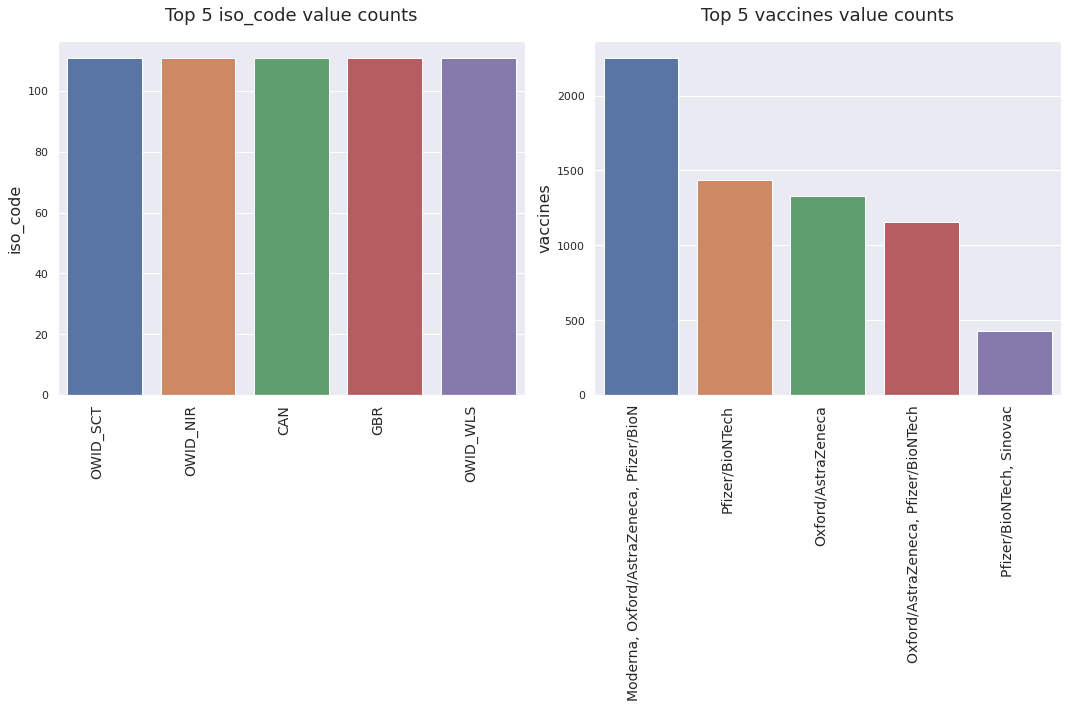

In [7]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')
                       
# Print top 10 Value counts for two important categorical columns
cols_to_visualize = ['iso_code', 'vaccines']
vz.plot_categorical_val_counts(covid_orig_df, cols_to_visualize, 
                                  print_values=False, top=5)

## Explore: Plot Column Correlations

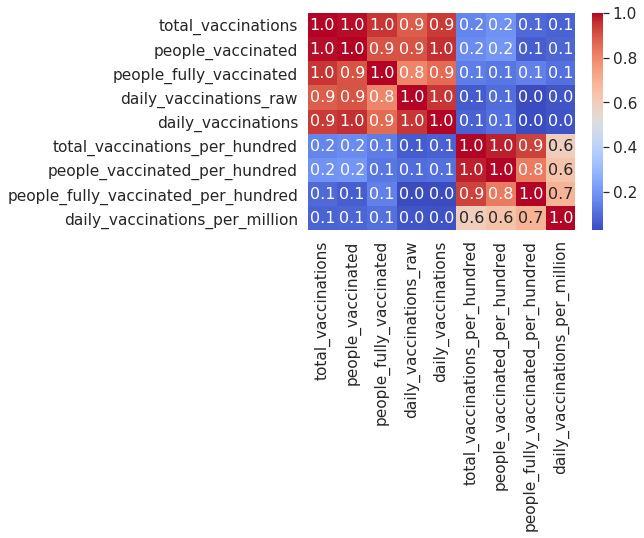

In [8]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Find Correlations between columns
cols_to_visualize = list(covid_orig_df.describe().columns)
vz.viz_columns_corr(covid_orig_df, cols_to_visualize)

## Explore: Plot Histograms for the numerical columns for the top Countries

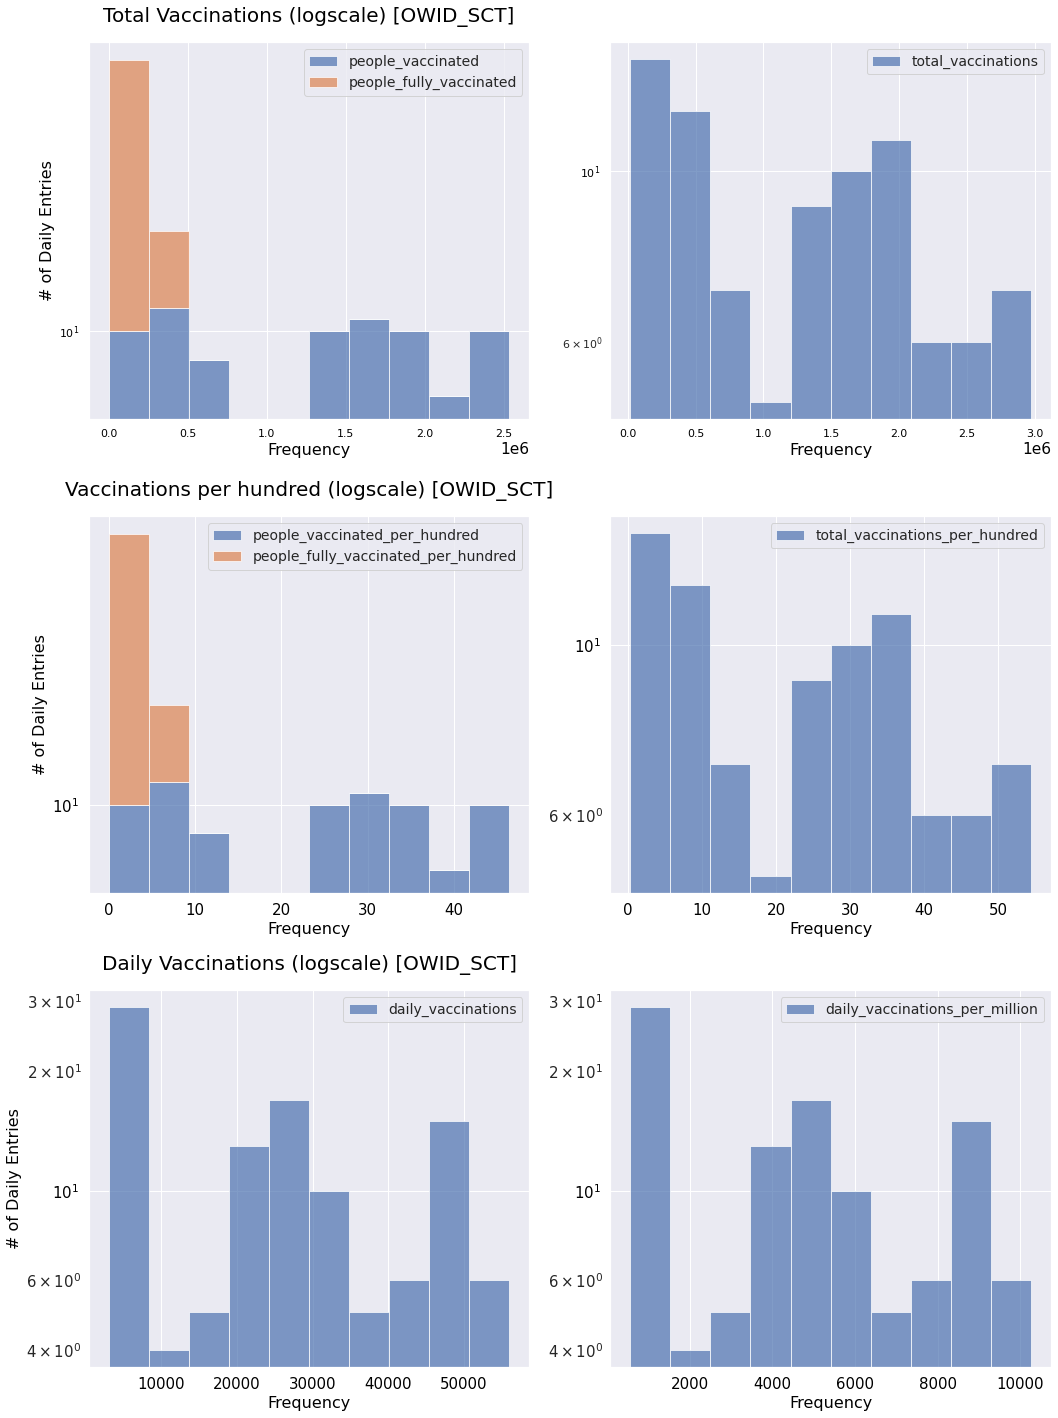

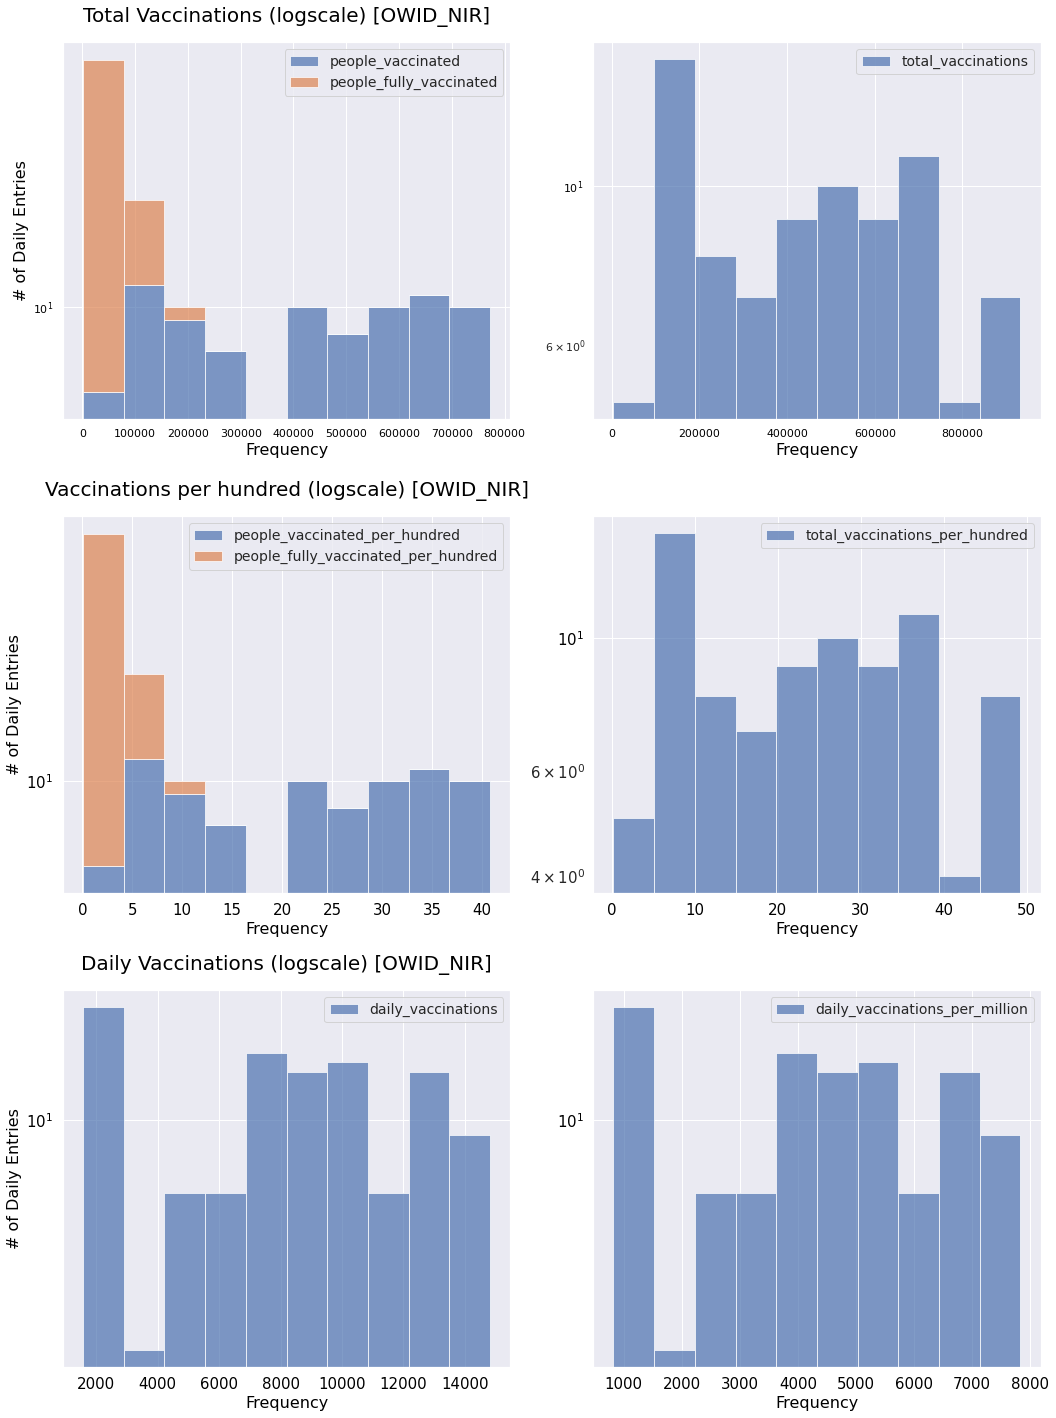

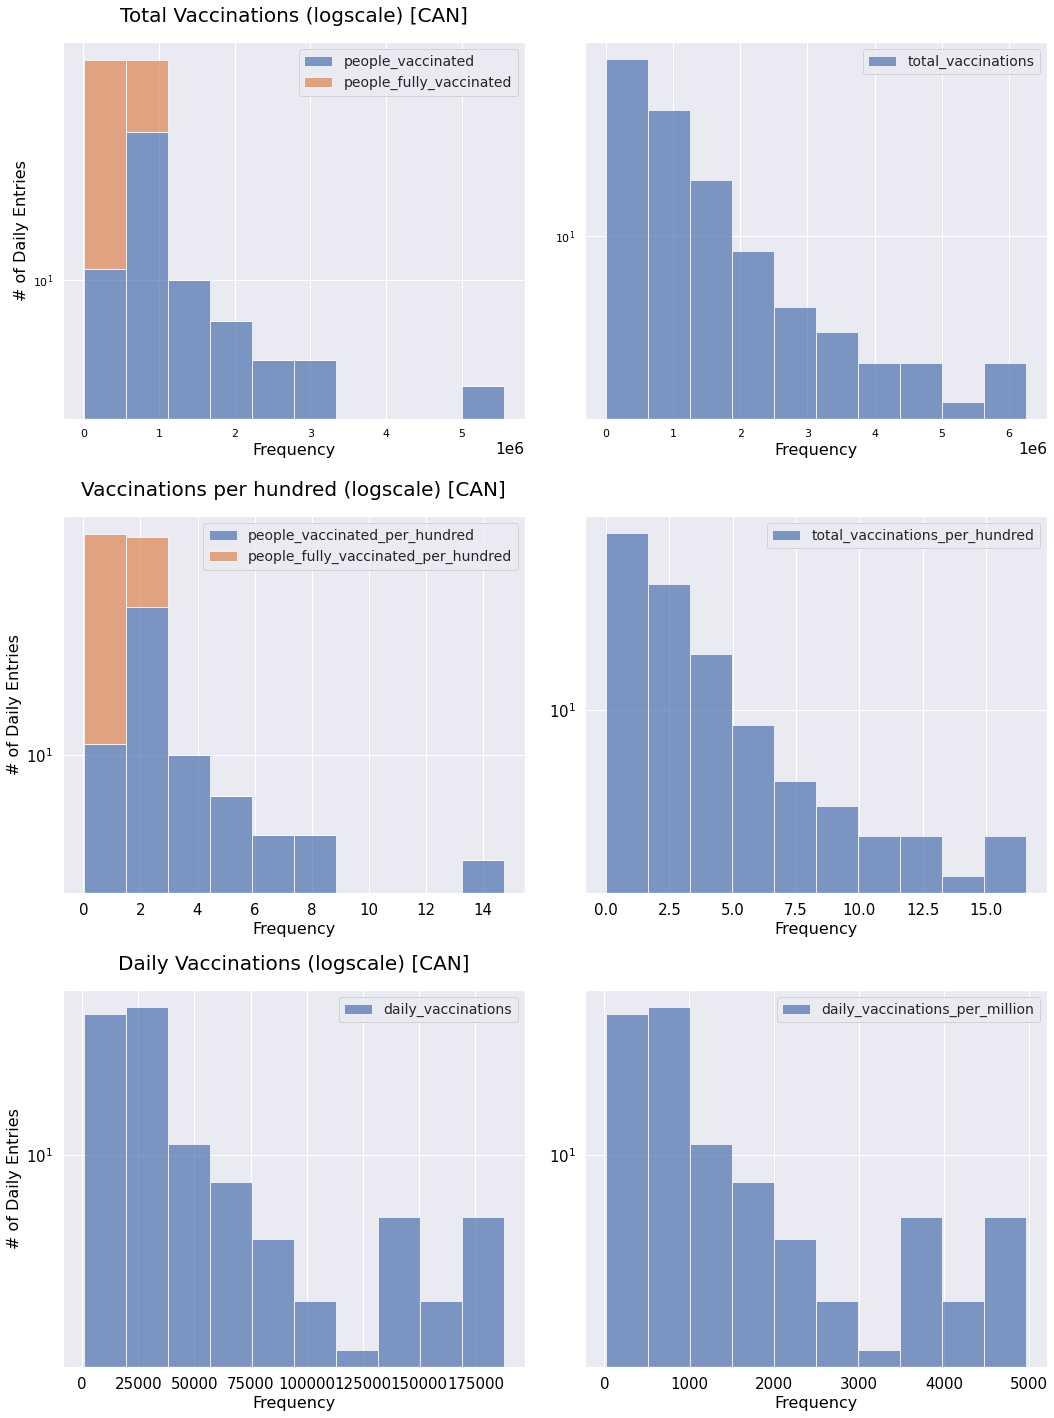

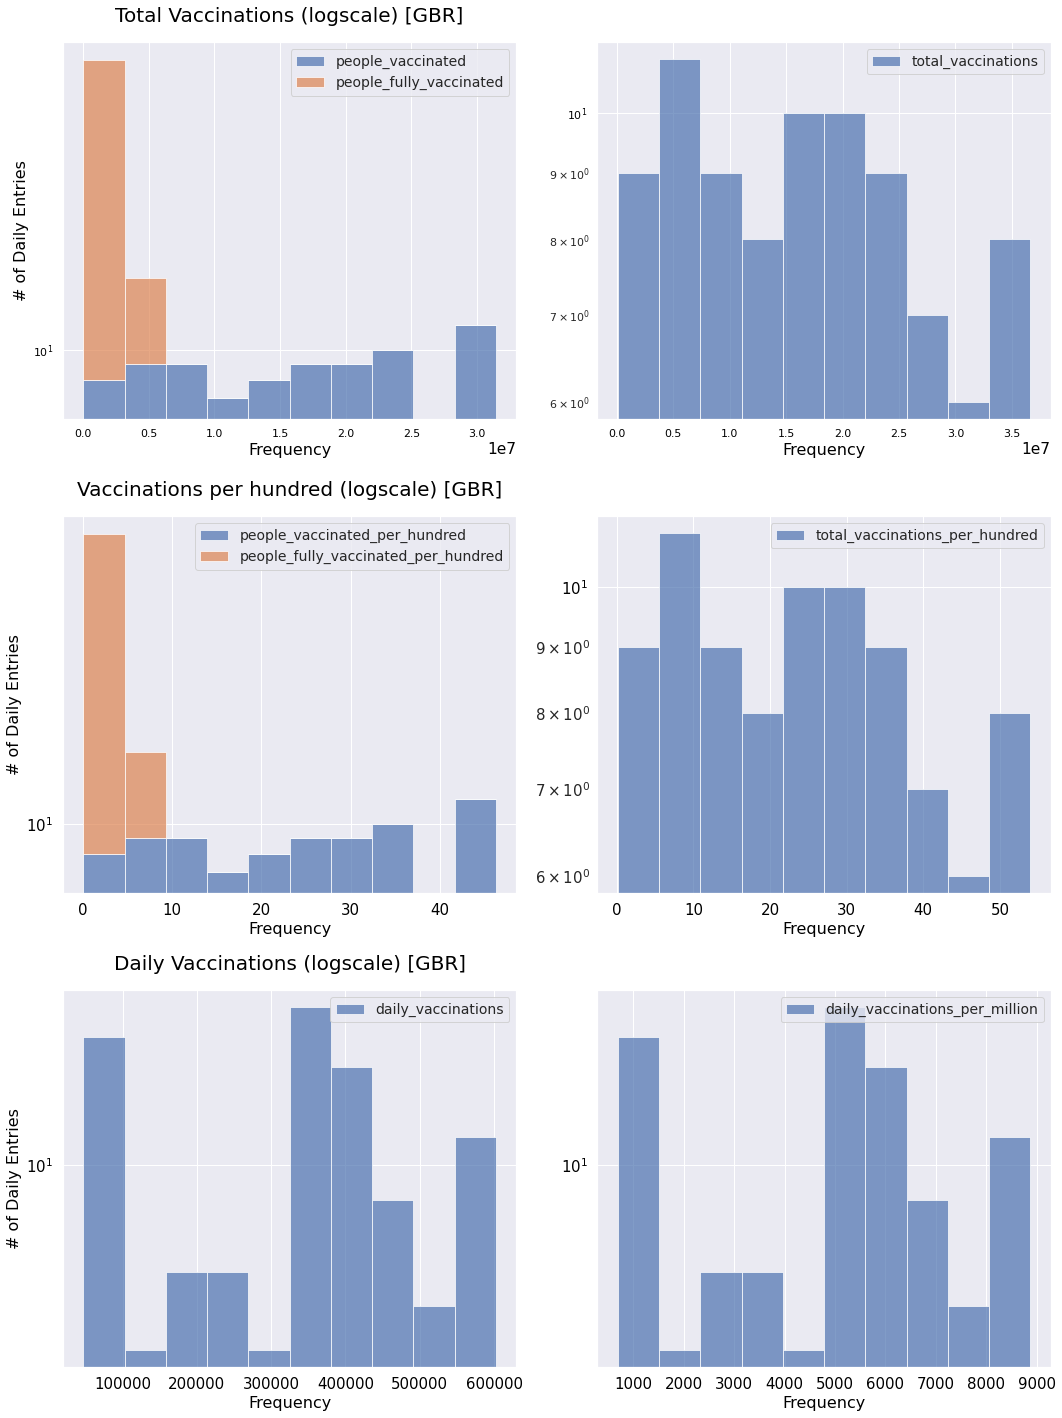

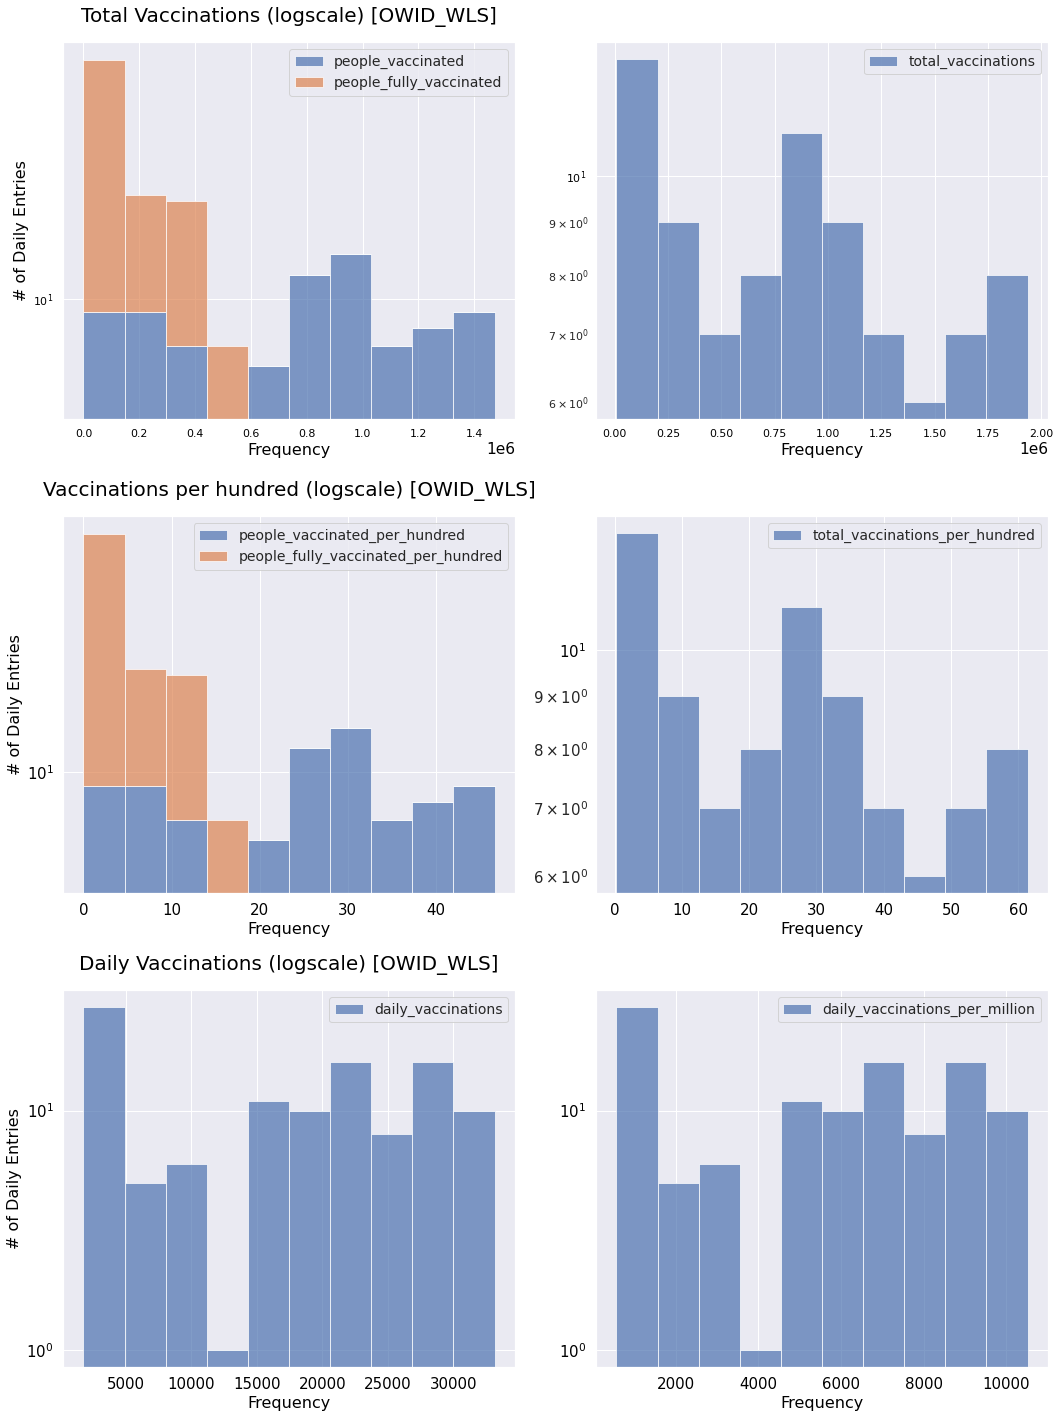

In [9]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Plot histograms with the values of important numerical columns
vz.plot_numerical_val_counts_per_country(covid_orig_df, top=5)

## Explore: Visualize null values

HeatMap Description
- -1: Exact Negative correlation represents that if the value of one variable is present then the value of other variables is definitely absent.
- 0: No correlation represents that variables values present or absent do not have any effect on one another.
- 1: Exact Positive correlation represents that if the value of one variable is present then the value of the other is definitely present

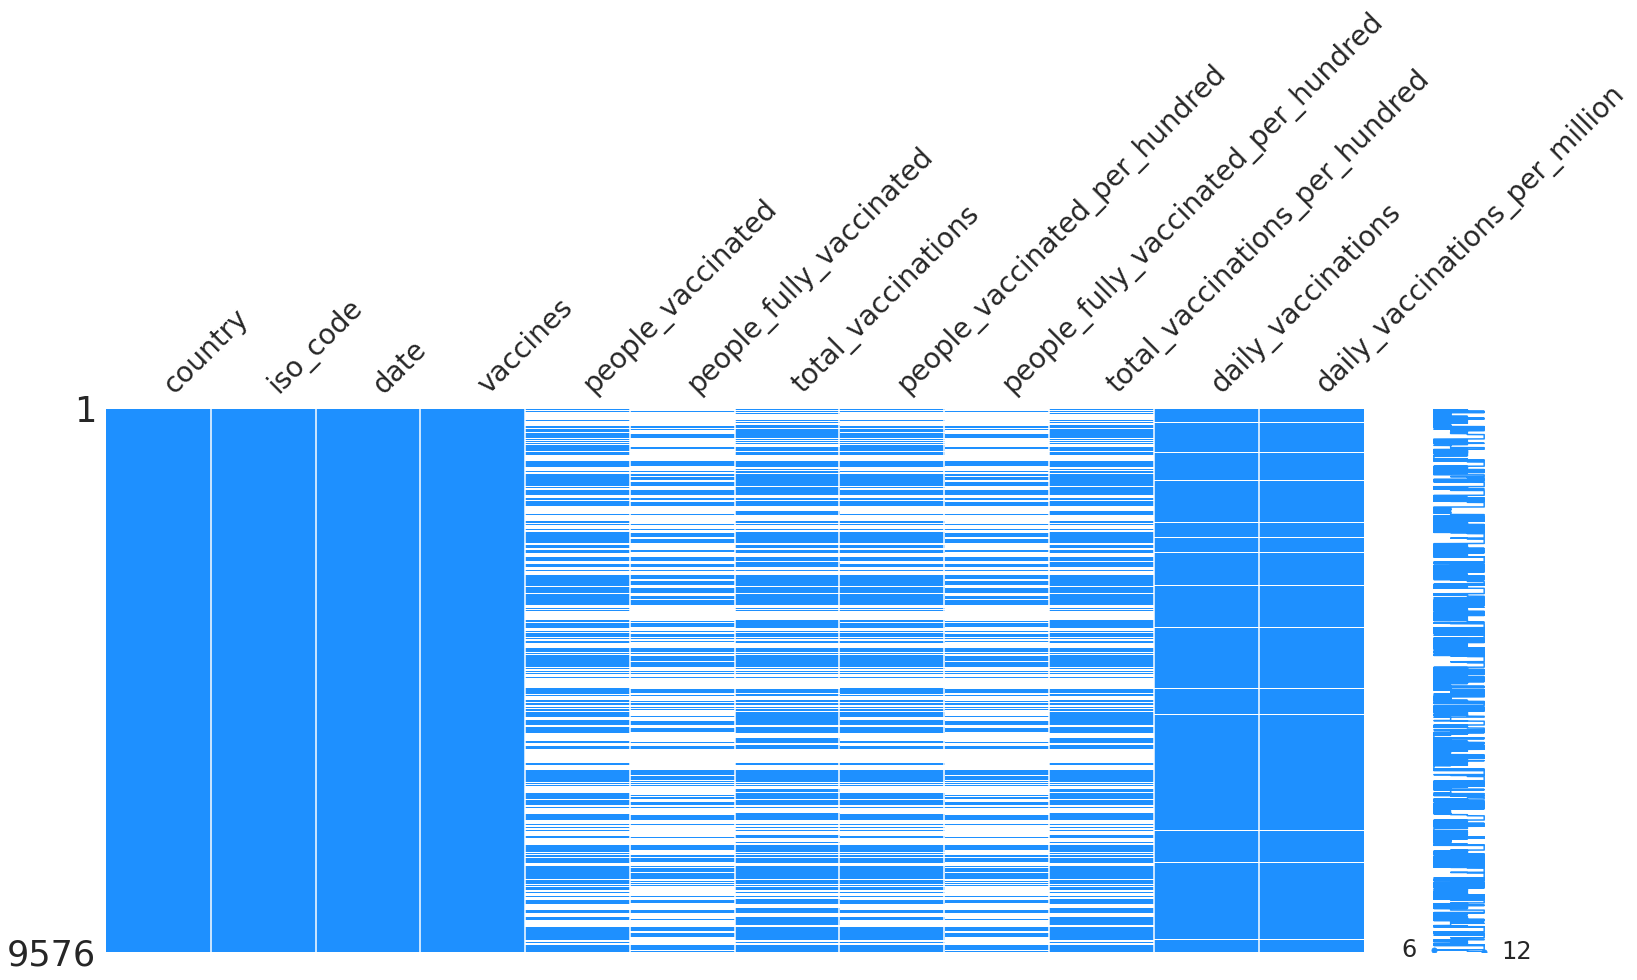

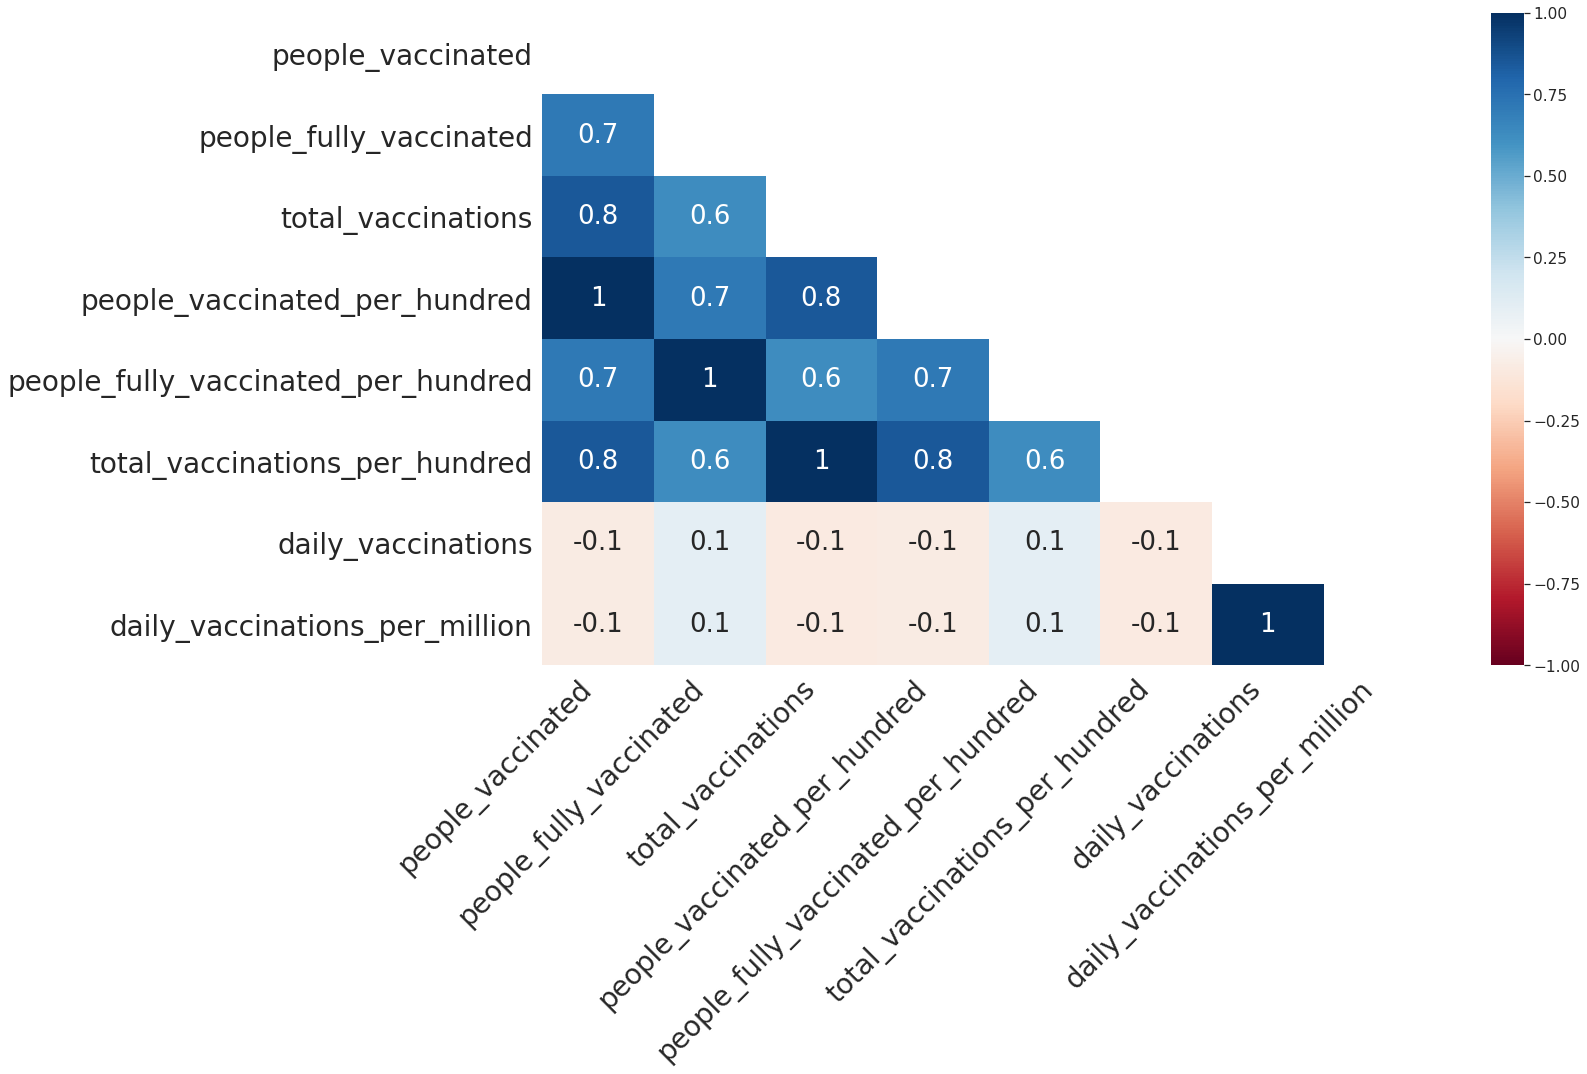

In [10]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Visualize Missing Values   
important_cols = ['country', 'iso_code', 'date', 'vaccines', 
                  'people_vaccinated', 'people_fully_vaccinated', 'total_vaccinations', 
                  'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 
                  'total_vaccinations_per_hundred','daily_vaccinations', 
                  'daily_vaccinations_per_million']
vz.viz_missing_values(covid_orig_df, important_cols, 
                      skip_1=False, skip_2=False, print_values=False)

# Transform/Clean the dataset

In [11]:
# Transform Date to a datetime column
covid_orig_df['date'] = pd.to_datetime(covid_orig_df.date)

## Transform: Fixing Nulls
In the previous section we see that the columns with most missing values are:
- people_vaccinated 
- people_fully_vaccinated
- total_vaccinations
- people_vaccinated_per_hundred
- people_fully_vaccinated_per_hundred
- total_vaccinations_per_hundred

We also find that the missing values of daily_vaccinations and daily_vaccinations_per_million are not correlated with any other columns. It's of course obvious that columns with their per_hunder or per_million versions are always missing at the same time.


### Fix Nulls: First let's fix the **non** `per_hundred` and `per_million` columns:
- `daily_vaccinations`
- `total_vaccinations`
- `people_vaccinated`
- `people_fully_vaccinated`

In [12]:
def d(df, cols):
    """ Function for printing the number of nulls per column"""
    df = df.loc[:, cols]
    missings = df.isna().sum()    
    return missings

In [13]:
# New DF version
covid_df_clean_1 = covid_orig_df.copy()

# Reload Lib    
reload_lib(nullib)
nf = nullib.NullsFixer(sort_col='date', group_col='iso_code')

# Columns to print their missing values
cols = ['country', 'iso_code', 'date', 'daily_vaccinations', 'total_vaccinations',
        'people_vaccinated', 'people_fully_vaccinated']


# Print the Missing values before
missings = d(covid_df_clean_1, cols)
logger.info(f"Missing Values Before:\n{missings}")

# Fix the NULLS
covid_df_clean_1 = nf.fix_and_infer(covid_df_clean_1)

# Print the Missing values before
missings = d(covid_df_clean_1, cols)
logger.info(f"Missing Values After:\n{missings}")


2021-04-25 15:08:20 JupyterMain  INFO     Missing Values Before:
country                       0
iso_code                      0
date                          0
daily_vaccinations          183
total_vaccinations         3804
people_vaccinated          4409
people_fully_vaccinated    5968
dtype: int64
2021-04-25 15:11:51 JupyterMain  INFO     Missing Values After:
country                    0
iso_code                   0
date                       0
daily_vaccinations         0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
dtype: int64


### Fix Nulls: Now fix `per_hundred` and `per_million` columns:
- `daily_vaccinations_per_million`
- `total_vaccinations_per_hundred`
- `people_vaccinated_per_hundred`
- `people_fully_vaccinated_per_hundred`

#### Columns w/ perc.: First Load external dataset with countries metadata

This dataset contains population data for the countries and some other useful metadata.

In [14]:
# Load the metadata dataset
if covid_conf['type'] == 'csv':
    countries_meta_orig_df = pd.read_csv(data_extra_path)
    logger.info("Dataset loaded.")
else:
    logger.error('Data type not supported!')

2021-04-25 15:11:51 JupyterMain  INFO     Dataset loaded.


In [15]:
# Print Columns info
logger.info(f"Dataframe shape: {countries_meta_orig_df.shape}")
# Print the first two rows
display(countries_meta_orig_df.head(n=2))

2021-04-25 15:11:51 JupyterMain  INFO     Dataframe shape: (265, 11)


,,"Population, total","Community health workers (per 1,000 people)",Unnamed: 3,Current health expenditure (% of GDP),"Life expectancy at birth, total (years)",People using at least basic sanitation services (% of population),"Hospital beds (per 1,000 people)",People with basic handwashing facilities including soap and water (% of population),"Physicians (per 1,000 people)","Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)"
0,Afghanistan,"38,041,754.0",..,NaN,9.4,64.5,43.4,0.4,37.7,0.3,13.9
1,Albania,"2,854,191.0",..,NaN,5.3,78.5,97.7,2.9,..,1.2,0.2


#### Columns w/ perc.: Transform the Metadata Dataset

1. Rename the columns
1. Drop Null Country rows
1. Fix the countries name to match our country names

In [16]:
# Preprocess the metadata dataset
countries_meta_df_clean_1 = countries_meta_orig_df.copy()
# Rename Columns
name_replacements = {
    ' ': 'country',
    'Country Code': 'iso_code',
    'Population, total': 'population',
    'Community health workers (per 1,000 people)': 'health_workers_per_1000',
    'Current health expenditure (% of GDP)': 'health_expenditure_per_gdp',
    'Hospital beds (per 1,000 people)': 'hospital_beds_per_1000',
    'Life expectancy at birth, total (years)': 'life_expectancy_at_birth',
    'People using at least basic sanitation services (% of population)': 'perc_using_sanitation_services',
    'People with basic handwashing facilities including soap and water (% of population)': 'perc_using_handwashing_facilities',
    'Physicians (per 1,000 people)': 'physicians_per_1000',
    'Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)': 'mortality_by_hygiene_per_100000'
}
countries_meta_df_clean_1 = countries_meta_df_clean_1.rename(columns=name_replacements)
# Drop unknown column
countries_meta_df_clean_1 = countries_meta_df_clean_1.drop(columns=["Unnamed: 3"])
# Drop Null Country rows
countries_meta_df_clean_1 = \
        countries_meta_df_clean_1[countries_meta_df_clean_1['country'].notna()]
# Strip country column
countries_meta_df_clean_1.loc[:, 'country'] = \
        countries_meta_df_clean_1['country'].str.strip()
# Fix Country names
countries_meta_df_clean_1.loc[:, 'country'] = countries_meta_df_clean_1['country']\
                                            .replace('Czech Republic', 'Czechia')\
                                            .replace('Brunei Darussalam', 'Brunei')\
                                            .replace('Cabo Verde', 'Cape Verde')\
                                            .replace('Slovak Republic', 'Slovakia')\
                                            .replace('Korea, Rep.', 'South Korea')\
                                            .replace('Faroe Islands', 'Faeroe Islands')\
                                            .replace('Lao PDR', 'Laos')\
                                            .replace('Ireland', 'Northern Ireland')\
                                            .str.replace(', The', '')\
                                            .str.replace(r',.*Rep.', '')\
                                            .str.replace('&', 'and')\
                                            .str.replace('St\.', 'Saint')\
                                            .str.replace('n Federation', '')\
                                            .str.replace(', RB', '')\
                                            .str.replace(' SAR, China', '')
# Fix the population column
countries_meta_df_clean_1.loc[:, 'population'] = countries_meta_df_clean_1['population']\
                                                .str.replace(',', '')
# Print 2 rows
display(countries_meta_df_clean_1.head(n=2))
logger.info(f"Countries Metadata Datatypes:\n{countries_meta_df_clean_1.dtypes}")

,country,population,health_workers_per_1000,health_expenditure_per_gdp,life_expectancy_at_birth,perc_using_sanitation_services,hospital_beds_per_1000,perc_using_handwashing_facilities,physicians_per_1000,mortality_by_hygiene_per_100000
0,Afghanistan,38041754.0,..,9.4,64.5,43.4,0.4,37.7,0.3,13.9
1,Albania,2854191.0,..,5.3,78.5,97.7,2.9,..,1.2,0.2


2021-04-25 15:11:51 JupyterMain  INFO     Countries Metadata Datatypes:
country                              object
population                           object
health_workers_per_1000              object
health_expenditure_per_gdp           object
life_expectancy_at_birth             object
perc_using_sanitation_services       object
hospital_beds_per_1000               object
perc_using_handwashing_facilities    object
physicians_per_1000                  object
mortality_by_hygiene_per_100000      object
dtype: object


#### Columns w/ perc.: Check the Common countries between the two datasets

If Countries are missing check if they are important before dropping

In [358]:
# Check the overlap between the 2 datasets
unique_countries_covid = list(covid_df_clean_1['country'].unique())
unique_countries_metadata = list(countries_meta_df_clean_1['country'].unique())

# Do we have 100% Overlap?
overlap = set(unique_countries_covid).issubset(unique_countries_metadata)
answer = "Yes" if overlap else "No"
logger.info(f"Are all the countries from out dataset included in the metadata dataset? "\
            f"{answer}")
# Print the countries missing
not_included = set(unique_countries_covid).difference(unique_countries_metadata)
logger.info(f"Number of daily vaccination entries for the countruies not included:")
display(covid_df_clean_1[covid_df_clean_1['country'].isin(not_included)]\
                                                    .country.value_counts())

2021-04-26 12:24:59 JupyterMain  INFO     Are all the countries from out dataset included in the metadata dataset? No
2021-04-26 12:24:59 JupyterMain  INFO     Number of daily vaccination entries for the countruies not included:


Wales               111
England             111
Scotland            111
Ireland              91
Northern Cyprus      71
Guernsey             65
Jersey               64
Falkland Islands     48
Anguilla             44
Saint Helena         41
Montserrat           38
Taiwan               13
Palestine             5
Name: country, dtype: int64

#### Columns w/ perc.: Drop the countries missing from the Vaccianation Dataset

The countries that are missing are either:
1. non-officially recognized countries for which we have data in another form (e.g. UK included Scotland, and England)
2. There are not too many entries for them

In [365]:
# New DF version
covid_df_clean_2 = covid_df_clean_1.copy()

# Let's drop them as for example UK includes England, Wales, Scotland
logger.info("Dropping the missing countries..")
covid_df_clean_2 = covid_df_clean_2[~covid_df_clean_2['country'].isin(not_included)]
unique_countries_covid = list(covid_df_clean_2['country'].unique())
# Overlap
overlap = set(unique_countries_covid).issubset(unique_countries_metadata)
answer = "Yes" if overlap else "No"
logger.info(f"Are all the countries from out dataset included in the metadata dataset? " \
            f"{answer}")



2021-04-26 12:26:41 JupyterMain  INFO     Dropping the missing countries..
2021-04-26 12:26:41 JupyterMain  INFO     Are all the countries from out dataset included in the metadata dataset? Yes


#### Columns w/ perc.: Use the new information to fix the `per_hunded` and `per_million` columns

In [19]:
# New DF version
countries_meta_df_clean_2 = countries_meta_df_clean_1.copy()

# Change the data types to numeric
metadata_cols = ['country', 'population', 'health_workers_per_1000', 'health_expenditure_per_gdp',
                 'hospital_beds_per_1000', 'life_expectancy_at_birth', 
                 'perc_using_sanitation_services', 'perc_using_handwashing_facilities', 
                 'physicians_per_1000', 'mortality_by_hygiene_per_100000']
for col in metadata_cols[1:]:
    countries_meta_df_clean_2.loc[:, col] = pd.to_numeric(countries_meta_df_clean_2[col], 
                                                          errors='coerce')

1. Divide the non `per_hundred` and `per_million` columns by the `population` column from the metadata dataset to infer their couterparts
1. Scale them in their 1-100 and 1-1 million ranges to fix errors
1. Transform the `per_million` column to `per_hundred`

In [366]:
# New DF version
covid_df_clean_3 = covid_df_clean_2.copy()

# Reload Lib
reload_lib(nullib)
nf = nullib.NullsFixer(sort_col='date', group_col='iso_code')

# Recalculate the per 100 and per million values using the new dataset
covid_df_clean_3 = nf.fill_with_population(covid_df_clean_3, countries_meta_df_clean_2)

# Then scale them to incorporate possible errors
# cols_to_scale = [("people_vaccinated_per_hundred", 100),
#                 ("people_fully_vaccinated_per_hundred", 100),
#                 ("total_vaccinations_per_hundred", 100), # can be > 100%
#                 ("daily_vaccinations_per_million", 1000000)]
# covid_df_clean_3 = nf.scale_cols(covid_df_clean_3, cols_to_scale)

# Transofrm the daily per million to daily per hundred
covid_df_clean_3['daily_vaccinations_per_hundred'] = \
    covid_df_clean_3['daily_vaccinations_per_million'] / 10000
# Drop the per million column
covid_df_clean_3 = covid_df_clean_3.drop(columns=['daily_vaccinations_per_million'])


,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,vaccines,source_name,source_website,daily_vaccinations_per_hundred


***We are done with the handling of nulls!***

### Transform: Data Enrichment

Let's utilize the metadata dataset and import some features to our vaccination Dataset

#### Enrichment: Visualize missing values on the Metadata Dataset

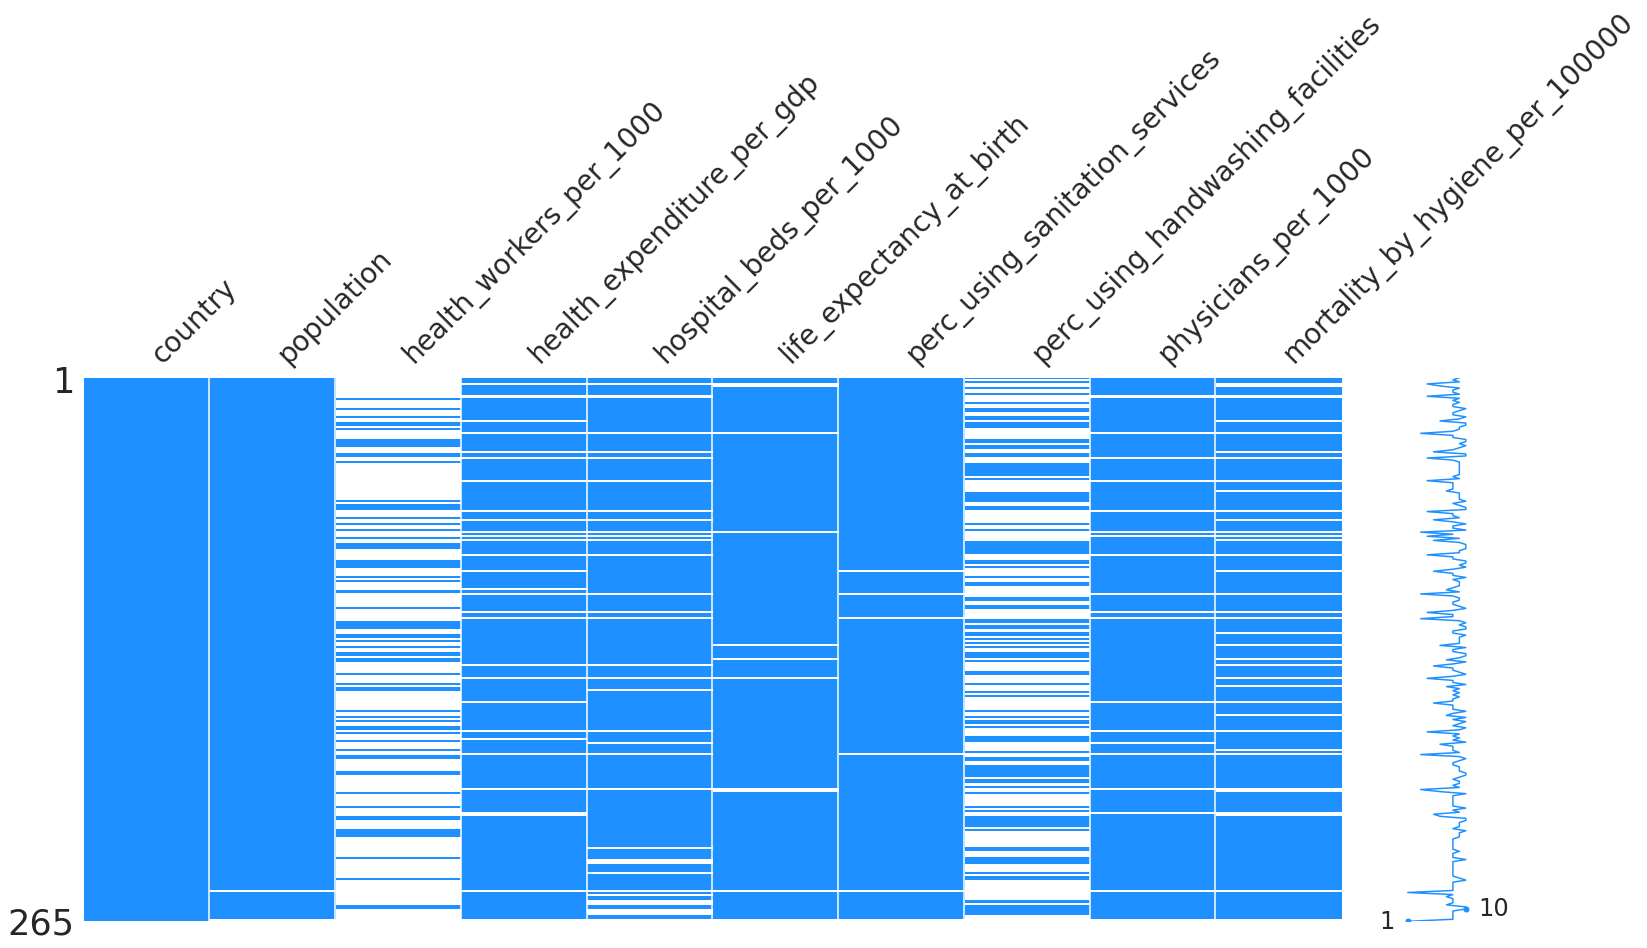

In [112]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Visualize 
vz.viz_missing_values(countries_meta_df_clean_2, metadata_cols, 
                      skip_2=True, print_values=False)

#### Enrichment: Drop Columns with too many missing values

In [113]:
# New DF Version
countries_meta_df_clean_3 = countries_meta_df_clean_2.copy()

# Drop columns with many nulls
cols_to_drop = ["health_workers_per_1000", "perc_using_handwashing_facilities"]
countries_meta_df_clean_3 = countries_meta_df_clean_3.drop(columns=cols_to_drop)
metadata_cols_kept = list(set(metadata_cols).difference(set(cols_to_drop)))

#### Enrichment: Interpolate missing values

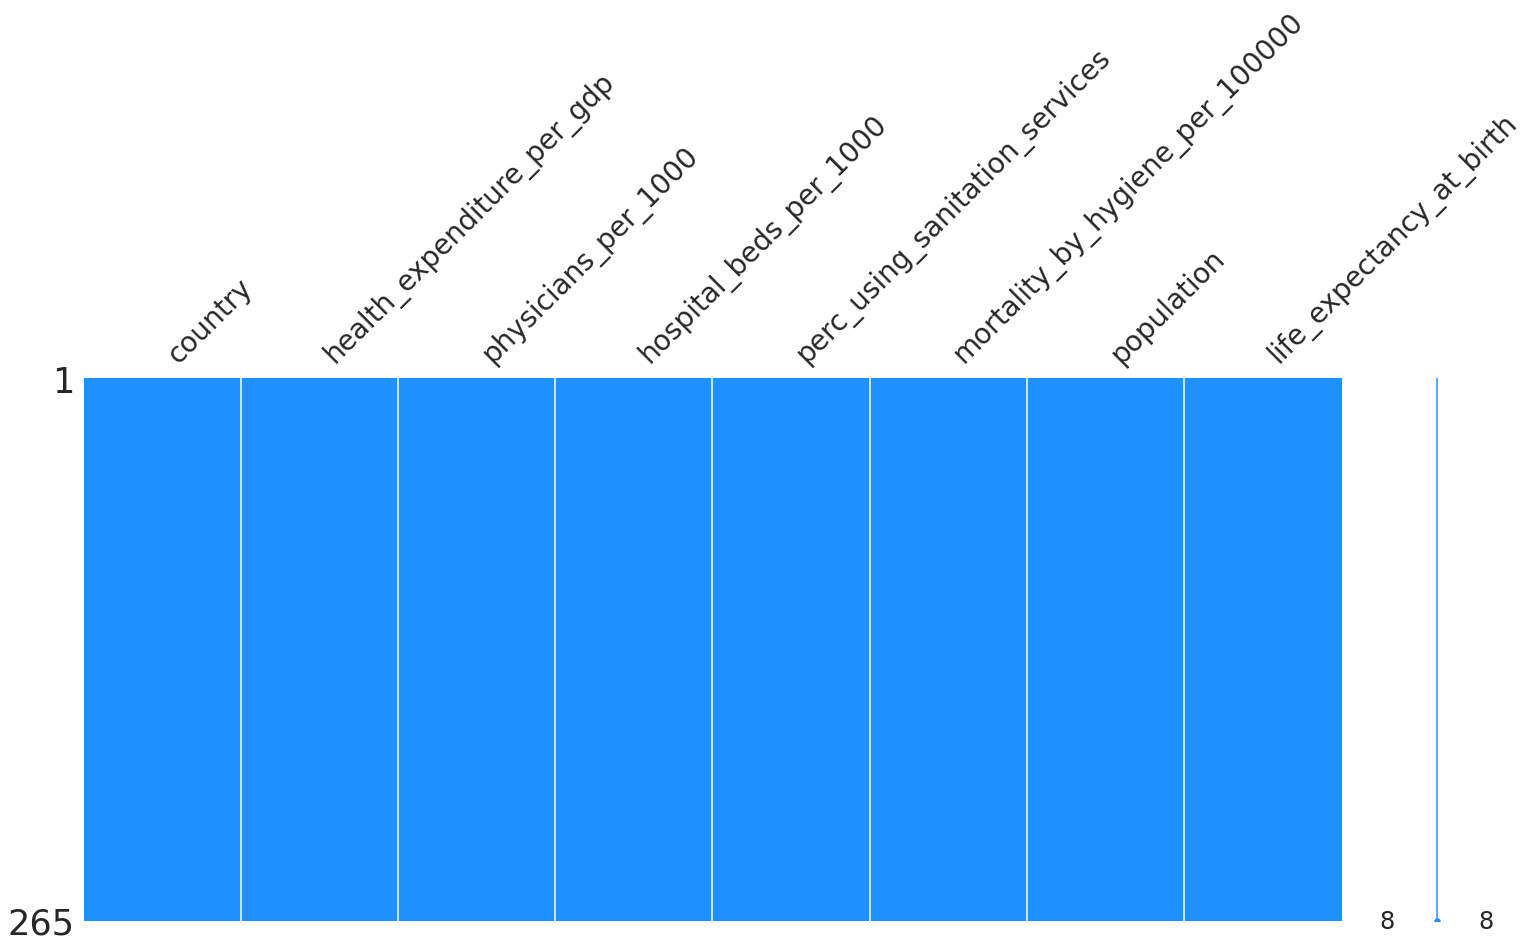

In [114]:
# New DF Version
countries_meta_df_clean_4 = countries_meta_df_clean_3.copy()

# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Fillna for the columns we kept using interpolation
countries_meta_df_clean_4 = countries_meta_df_clean_4.interpolate()
# Visualizer
vz.viz_missing_values(countries_meta_df_clean_4, metadata_cols_kept, 
                      skip_2=True, print_values=False)

#### Enrichment: Merge our dataset with the metadata dataset

In [368]:
# New DF Version
covid_df_clean_4 = covid_df_clean_3.copy()
# Now match these values with the covid dataset
covid_df_clean_4 = covid_df_clean_4.merge(countries_meta_df_clean_4, 
                                          on='country', how='left')
# Print the first two rows
display(covid_df_clean_4.head(2).transpose())

,0,1
country,Northern Ireland,United Kingdom
iso_code,OWID_NIR,GBR
date,2020-12-13 00:00:00,2020-12-13 00:00:00
total_vaccinations,3623.0,86465.0
people_vaccinated,3623.0,86465.0
people_fully_vaccinated,0.0,0.0
daily_vaccinations_raw,NaN,NaN
daily_vaccinations,3623.0,86465.0
total_vaccinations_per_hundred,0.19,0.13
people_vaccinated_per_hundred,0.19,0.13


### Transform: Feature Engineering

#### Feat. Eng.: OneHotEncode Vaccines

In [370]:
# New DF Version
covid_df_clean_5 = covid_df_clean_4.copy()
# Print the first two vaccine rows
display(covid_df_clean_4[['vaccines']].head(2))

# OneHotEncode the 'vaccines' columns
onehotencoded_df_1 = covid_df_clean_4.vaccines.str\
                                   .split('\s*,\s*', expand=True)\
                                   .stack()\
                                   .str.get_dummies()\
                                   .add_prefix('vaccine_').sum(level=0)
# OneHotEncode the 'country' columns
# onehotencoded_df_2 = pd.get_dummies(covid_df_clean_4.iso_code, prefix='country')

# Merge it with our dataset
covid_df_clean_5 = covid_df_clean_5.join(onehotencoded_df_1)#.join(onehotencoded_df_2)

# Print the first two rows
display(covid_df_clean_5.head(2).transpose())


,vaccines
0,"Oxford/AstraZeneca, Pfizer/BioNTech"
1,"Oxford/AstraZeneca, Pfizer/BioNTech"


,0,1
country,Northern Ireland,United Kingdom
iso_code,OWID_NIR,GBR
date,2020-12-13 00:00:00,2020-12-13 00:00:00
total_vaccinations,3623.0,86465.0
people_vaccinated,3623.0,86465.0
people_fully_vaccinated,0.0,0.0
daily_vaccinations_raw,NaN,NaN
daily_vaccinations,3623.0,86465.0
total_vaccinations_per_hundred,0.19,0.13
people_vaccinated_per_hundred,0.19,0.13


# Plot what we currenlty have

## Plot: Top countries with the best records

Regarding:
- Total vaccinations
- Total vaccinations per 100
- Avg daily vaccinations per 100

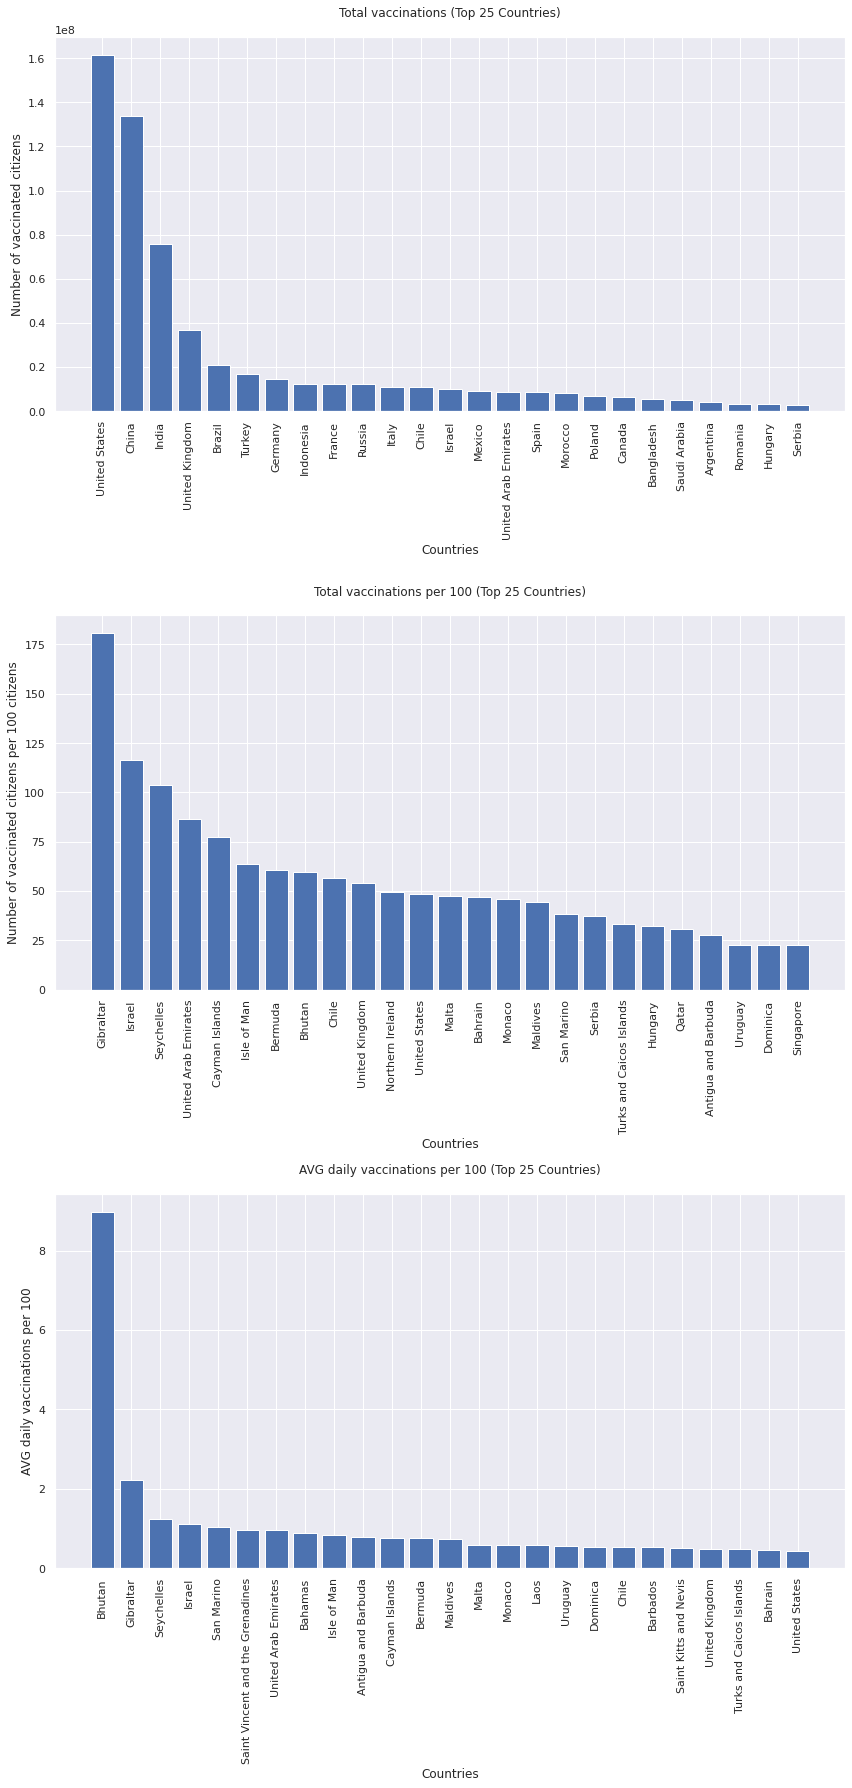

In [319]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='country', text_color='black')

# Plot the countries with best records on some of the columns
top_n = 25
vz.viz_top_countries_accumulated_statistics(covid_df_clean_5, top_n=top_n)

## Plot: The daily progress of the top countries

Regarding:
- People vaccinated per 100
- People fully vaccinated per 100
- Total vaccinations per 100
- Daily vaccinations per 100

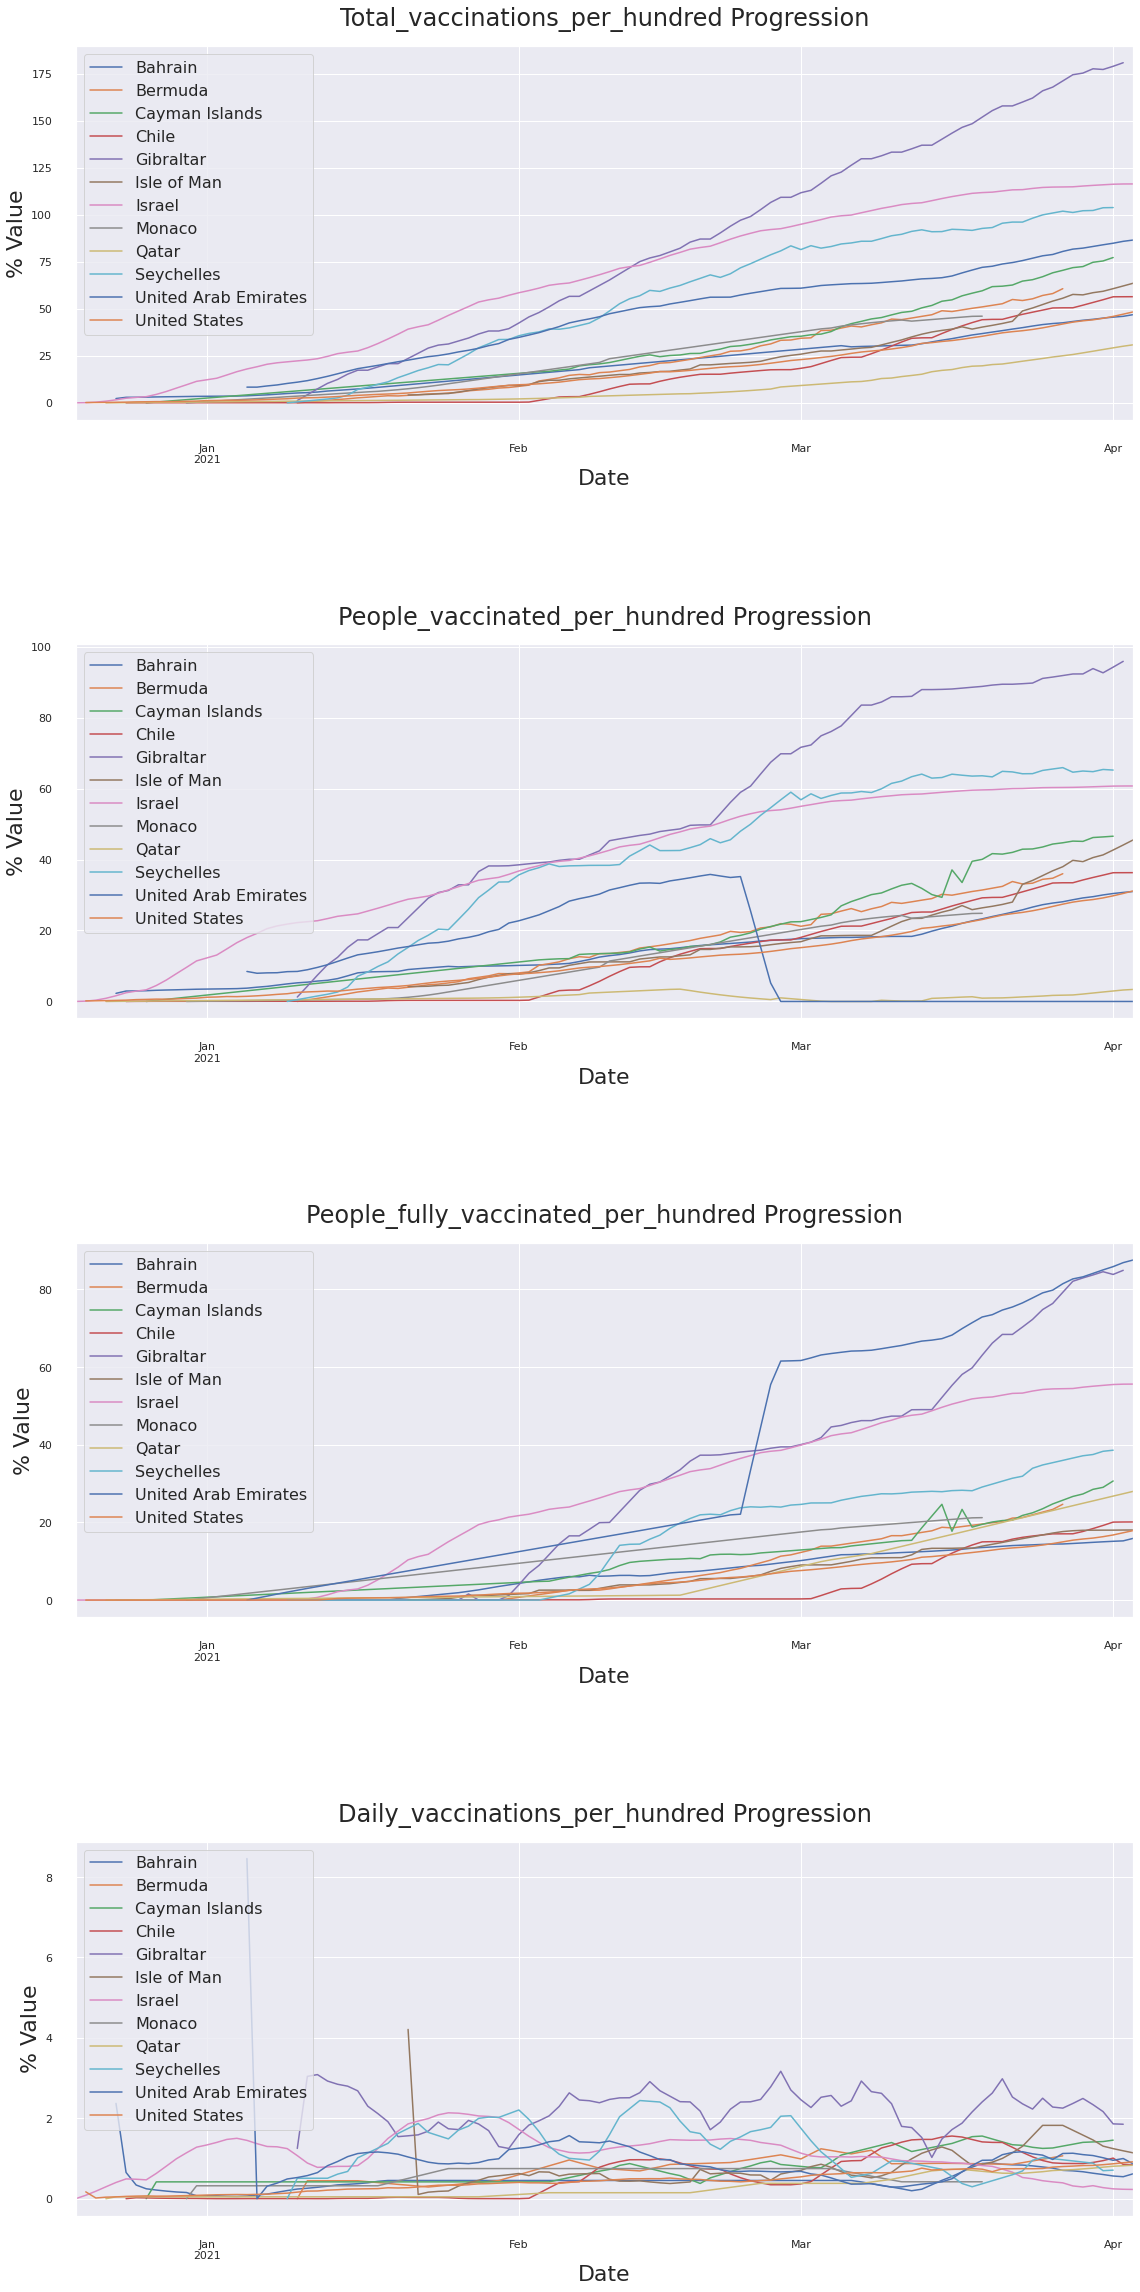

In [320]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='country', text_color='black')

# Plot the progress of the top n countries
top_n = 12
# top_sort_by = 'total_vaccinations_per_hundred'
# top_sort_by = 'people_vaccinated_per_hundred'
top_sort_by = 'people_fully_vaccinated_per_hundred'
# top_sort_by = 'daily_vaccinations_per_hundred'
vz.viz_top_countries_progress(covid_df_clean_5, top_sort_by=top_sort_by, top_n=top_n)

2021-04-26 11:53:22 Visualizer   INFO     vaccine_Covaxin: 79
2021-04-26 11:53:22 Visualizer   INFO     vaccine_EpiVacCorona: 110
2021-04-26 11:53:22 Visualizer   INFO     vaccine_Johnson&Johnson: 150
2021-04-26 11:53:22 Visualizer   INFO     vaccine_Moderna: 2789
2021-04-26 11:53:22 Visualizer   INFO     vaccine_Oxford/AstraZeneca: 5281
2021-04-26 11:53:22 Visualizer   INFO     vaccine_Pfizer/BioNTech: 5859
2021-04-26 11:53:22 Visualizer   INFO     vaccine_Sinopharm/Beijing: 1236
2021-04-26 11:53:22 Visualizer   INFO     vaccine_Sinopharm/Wuhan: 198
2021-04-26 11:53:22 Visualizer   INFO     vaccine_Sinovac: 946
2021-04-26 11:53:22 Visualizer   INFO     vaccine_Sputnik V: 1191


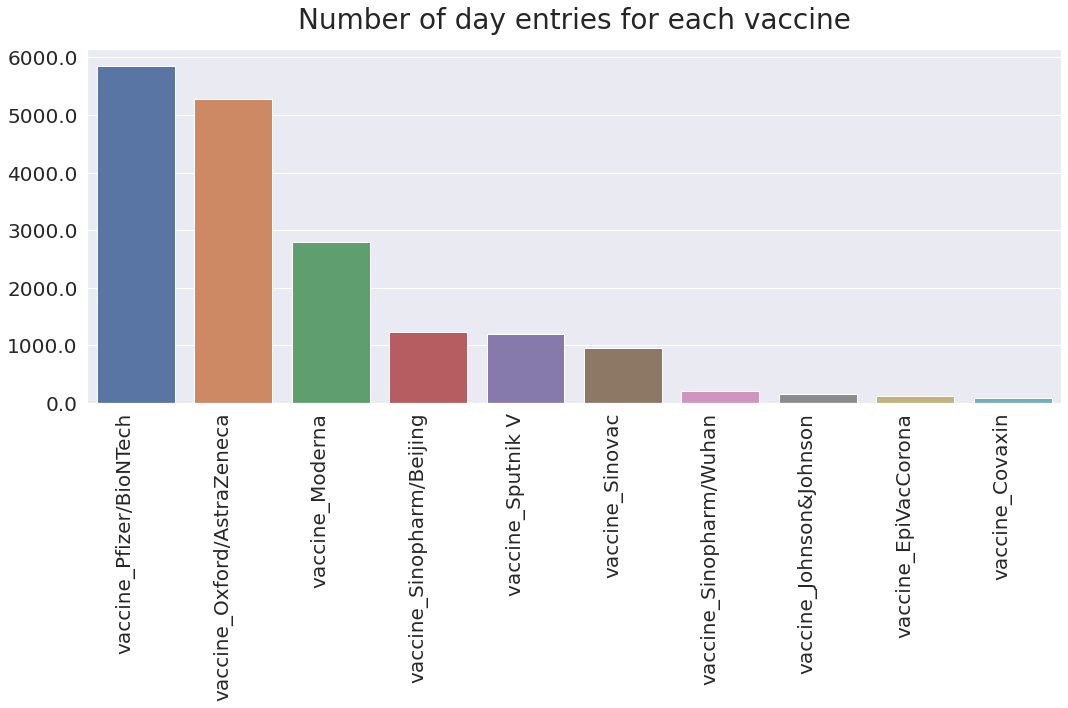

In [321]:
# Reload Lib
reload_lib(vizlib)
vz = vizlib.Visualizer(sort_col='date', group_col='iso_code', text_color='black')

# Print top 10 Value counts for two important categorical columns
cols_to_visualize = ['vaccine_Covaxin', 'vaccine_EpiVacCorona', 'vaccine_Johnson&Johnson', 
                     'vaccine_Moderna', 'vaccine_Oxford/AstraZeneca', 'vaccine_Pfizer/BioNTech', 
                     'vaccine_Sinopharm/Beijing', 'vaccine_Sinopharm/Wuhan', 'vaccine_Sinovac', 
                     'vaccine_Sputnik V']
vz.plot_vaccines_val_counts(covid_df_clean_5, cols_to_visualize, 
                             print_values=True, top=5)

# Training

Train an LSTM

In [322]:
import tensorflow as tf

## Training: Drop irrelevant columns 

Let's keep two versions, one with the final columns from our dataset and one with the extra columns from the metadata dataset

In [371]:
# New DF
covid_df_clean_6 = covid_df_clean_5.copy()

# Let's drop the column we won't use
cols_to_drop = ['country', 'source_name', 'source_website', 'population', 
                'vaccines',  'daily_vaccinations_raw', 'daily_vaccinations', 
                'total_vaccinations',  'people_vaccinated', 'people_fully_vaccinated']
covid_df_clean_6 = covid_df_clean_6.drop(columns=cols_to_drop)
covid_df_clean_enriched_6 = covid_df_clean_6.copy()

# Drop the metadata columns in a new df version
metadata_cols = ['health_expenditure_per_gdp', 'life_expectancy_at_birth', 
                 'perc_using_sanitation_services', 'hospital_beds_per_1000', 
                 'physicians_per_1000', 'mortality_by_hygiene_per_100000']
covid_df_clean_6 = covid_df_clean_6.drop(columns=metadata_cols)


,iso_code,date,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_hundred,vaccine_Covaxin,vaccine_EpiVacCorona,vaccine_Johnson&Johnson,vaccine_Moderna,vaccine_Oxford/AstraZeneca,vaccine_Pfizer/BioNTech,vaccine_Sinopharm/Beijing,vaccine_Sinopharm/Wuhan,vaccine_Sinovac,vaccine_Sputnik V


## Training: Separate the Dataset into weeks

Drop rows from the last until you can split the dataset into weeks

In [379]:
# New DF
covid_df_clean_7 = covid_df_clean_6.copy()
covid_df_clean_enriched_7 = covid_df_clean_enriched_6.copy()

# Reload Lib
reload_lib(preplib)
prep = preplib.Preprocess(sort_col='date', group_col='iso_code')

logger.info("Columns before pivoting:")
display(covid_df_clean_7.columns)

# Pivot the static columns
covid_df_clean_7 = prep.pivot_columns_on_country(covid_df_clean_7)

# Do the same for the enriched dataset
covid_df_clean_enriched_7 = prep.pivot_columns_on_country(covid_df_clean_enriched_7)

# Drop the date and iso_code columns
covid_df_clean_7 = covid_df_clean_7.set_index("date").sort_index().sort_index()
covid_df_clean_enriched_7 = covid_df_clean_enriched_7.set_index("date").sort_index()

logger.info("Columns after pivoting:")
display(covid_df_clean_7.columns)

# Fill Null Values with zeros
logger.info("First Row before Filling the Nulls:")
display(covid_df_clean_7.head(1).transpose())

covid_df_clean_7 = covid_df_clean_7.fillna(0) 
covid_df_clean_enriched_7 = covid_df_clean_enriched_7.fillna(0)

logger.info("First Row after Filling the Nulls:")
display(covid_df_clean_7.head(1).transpose())


2021-04-26 12:35:53 JupyterMain  INFO     Columns before pivoting:


Index(['iso_code', 'date', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'daily_vaccinations_per_hundred', 'vaccine_Covaxin',
       'vaccine_EpiVacCorona', 'vaccine_Johnson&Johnson', 'vaccine_Moderna',
       'vaccine_Oxford/AstraZeneca', 'vaccine_Pfizer/BioNTech',
       'vaccine_Sinopharm/Beijing', 'vaccine_Sinopharm/Wuhan',
       'vaccine_Sinovac', 'vaccine_Sputnik V'],
      dtype='object')

2021-04-26 12:35:53 JupyterMain  INFO     Columns after pivoting:


Index(['daily_vaccinations_per_hundred_AFG',
       'daily_vaccinations_per_hundred_AGO',
       'daily_vaccinations_per_hundred_ALB',
       'daily_vaccinations_per_hundred_AND',
       'daily_vaccinations_per_hundred_ARE',
       'daily_vaccinations_per_hundred_ARG',
       'daily_vaccinations_per_hundred_ATG',
       'daily_vaccinations_per_hundred_AUS',
       'daily_vaccinations_per_hundred_AUT',
       'daily_vaccinations_per_hundred_AZE',
       ...
       'vaccine_Sputnik V_TUR', 'vaccine_Sputnik V_UGA',
       'vaccine_Sputnik V_UKR', 'vaccine_Sputnik V_URY',
       'vaccine_Sputnik V_USA', 'vaccine_Sputnik V_VCT',
       'vaccine_Sputnik V_VEN', 'vaccine_Sputnik V_VNM',
       'vaccine_Sputnik V_ZAF', 'vaccine_Sputnik V_ZWE'],
      dtype='object', length=2142)

2021-04-26 12:35:53 JupyterMain  INFO     First Row before Filling the Nulls:


date,2020-12-13
daily_vaccinations_per_hundred_AFG,NaN
daily_vaccinations_per_hundred_AGO,NaN
daily_vaccinations_per_hundred_ALB,NaN
daily_vaccinations_per_hundred_AND,NaN
daily_vaccinations_per_hundred_ARE,NaN
...,...
vaccine_Sputnik V_VCT,NaN
vaccine_Sputnik V_VEN,NaN
vaccine_Sputnik V_VNM,NaN
vaccine_Sputnik V_ZAF,NaN


2021-04-26 12:35:53 JupyterMain  INFO     First Row after Filling the Nulls:


date,2020-12-13
daily_vaccinations_per_hundred_AFG,0.0
daily_vaccinations_per_hundred_AGO,0.0
daily_vaccinations_per_hundred_ALB,0.0
daily_vaccinations_per_hundred_AND,0.0
daily_vaccinations_per_hundred_ARE,0.0
...,...
vaccine_Sputnik V_VCT,0.0
vaccine_Sputnik V_VEN,0.0
vaccine_Sputnik V_VNM,0.0
vaccine_Sputnik V_ZAF,0.0


## Training: Change Datatypes

Make all datatypes float64

In [388]:
# New DF
covid_df_clean_8 = covid_df_clean_7.copy()
covid_df_clean_enriched_8 = covid_df_clean_enriched_7.copy()

# Change teh datatypes
covid_df_clean_8 = covid_df_clean_8.astype(np.float64)
covid_df_clean_enriched_8 = covid_df_clean_enriched_8.astype(np.float32)

logger.info("Changed all datatypes to float32.")

2021-04-26 12:50:42 JupyterMain  INFO     Changed all datatypes to float32.


In [216]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test



train, test = split_dataset(covid_df_clean_7)

ValueError: array split does not result in an equal division

# Evaluation

In [ ]:
# Further feature engineering to find bottlnecks
# Create columns that indicate the average daily values for the past 3, 7, 14 days
# Similarly to GNU/Linux's Load Average
# Target columns can be a boolean that indicates if today's value is far too low compared
# to previous days
# Use these columns to guess bottlnecks
# Plotting a decision for these values tree may be useful

# Visualize Results